Train Basic Models with Day, Month, Arrival Time to Predict Waiting Time

### Import Library

In [1]:
import pickle
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, RobustScaler

### Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('Dataset/pre_processed_dataset.csv')

In [3]:
df.columns

Index(['SDST', 'SDET', 'SERVICE_NAME', 'TKIS_TIME', 'encoded_service_name',
       'waiting_time', 'arrival_time', 'arrival_day', 'arrival_month',
       'arrival_year'],
      dtype='object')

In [4]:
df.tail(5)

,SDST,SDET,SERVICE_NAME,TKIS_TIME,encoded_service_name,waiting_time,arrival_time,arrival_day,arrival_month,arrival_year
280041,2022-03-02 14:21:55,2022-03-02 14:24:27,Deposit,2022-03-02 14:19:24,14,151.0,51564,2,3,2022
280042,2022-03-02 14:24:27,2022-03-02 14:27:51,Deposit,2022-03-02 14:19:53,14,274.0,51593,2,3,2022
280043,2022-03-02 14:27:51,2022-03-02 14:28:06,Deposit,2022-03-02 14:20:48,14,423.0,51648,2,3,2022
280044,2022-03-02 14:30:49,2022-03-02 14:32:01,Withdrawal,2022-03-02 14:22:22,28,507.0,51742,2,3,2022
280045,2022-03-02 14:28:06,2022-03-02 14:28:15,Deposit,2022-03-02 14:23:41,14,265.0,51821,2,3,2022


Normalization

In [5]:
# Define features to normalize
features = ['encoded_service_name', 'arrival_time', 'arrival_year']

# Ensure relevant columns are numeric
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# Apply Z-score normalization
df_norm = df.copy()  # Create a copy of the DataFrame to store normalized values
# df_norm['waiting_time'] = df_norm[['waiting_time']].apply(zscore, axis=0)

# Apply log transformation for skewed
df_norm[features] = df[features].apply(lambda x: np.log1p(x))

# Apply Robust transformation for outlier
scaler_robust = RobustScaler()
df_norm[features] = scaler_robust.fit_transform(df_norm[features])

# Define features (X) and target (y)
X = df_norm[['encoded_service_name', 'arrival_time', 'arrival_day', 'arrival_month', 'arrival_year']].values
y = df_norm['waiting_time'].values

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
X_train[0]
y_train[0]

-0.7574434718053727

Without normalization

In [ ]:
# Define features (X) and target (y)
X = df[['encoded_service_name', 'arrival_time', 'arrival_day', 'arrival_month', 'arrival_year']].values
y = df['waiting_time'].values

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Encode service names (Assuming categorical services)
label_encoder = LabelEncoder()
df['encoded_service_name'] = label_encoder.fit_transform(df['SERVICE_NAME'])+1

# Initialize a dictionary to store results
results = {}
predictions = {}
# Function to evaluate models and store predictions for plotting
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = {'Actual': y_test, 'Predicted': y_pred}  # Store actual and predicted values
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}
    print(f"{name} Results:")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}\n")
    # Save the model
    with open(f'Models/{name}_model.pkl', 'wb') as model_file:
        pickle.dump((model, label_encoder), model_file)
    print(f"{name} model saved successfully!\n")

Linear_Regression Results:
MAE: 1074.2714128381092, MSE: 2421484.6723312414, RMSE: 1556.1120372040186, R²: 0.06688853976915277

Linear_Regression model saved successfully!

Decision_Tree_Regressor Results:
MAE: 229.49862524549187, MSE: 521834.2313693983, RMSE: 722.3809461561111, R²: 0.7989128293086578

Decision_Tree_Regressor model saved successfully!

Random_Forest_Regressor Results:
MAE: 227.26332618810002, MSE: 327097.1678638158, RMSE: 571.9240927464201, R²: 0.8739541408499041

Random_Forest_Regressor model saved successfully!

XGBoost_Regressor Results:
MAE: 229.14936517823176, MSE: 392439.0192389769, RMSE: 626.4495344710353, R²: 0.8487748650743674

XGBoost_Regressor model saved successfully!



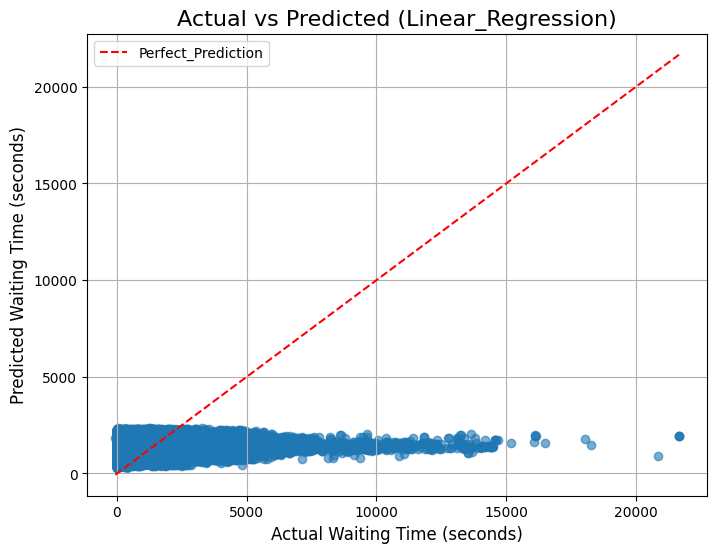

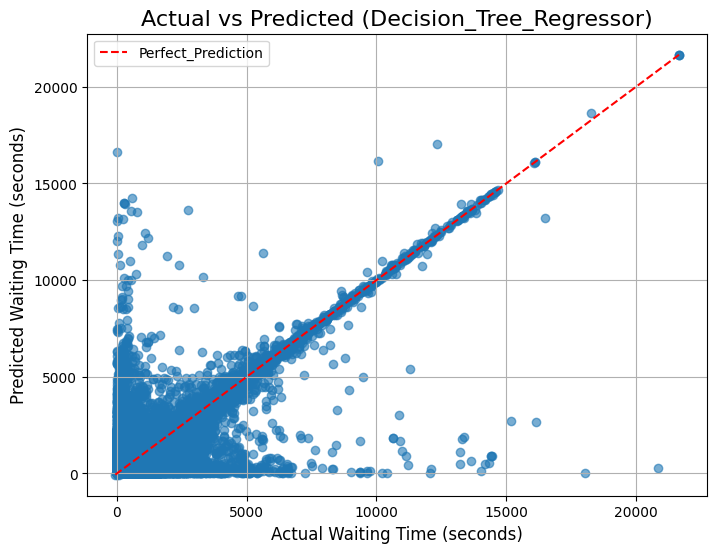

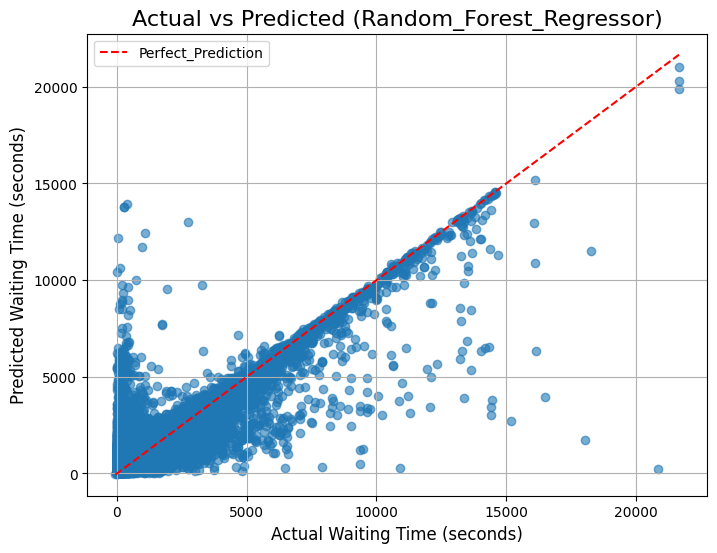

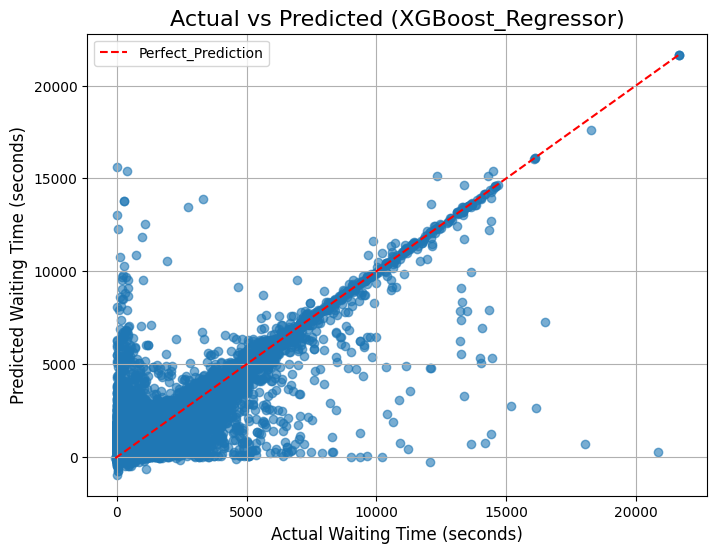


Summary of Results:
                                 MAE           MSE         RMSE        R²
Linear_Regression        1074.271413  2.421485e+06  1556.112037  0.066889
Decision_Tree_Regressor   229.498625  5.218342e+05   722.380946  0.798913
Random_Forest_Regressor   227.263326  3.270972e+05   571.924093  0.873954
XGBoost_Regressor         229.149365  3.924390e+05   626.449534  0.848775


In [16]:
# 1. Linear Regression
lr_model = LinearRegression()
evaluate_model("Linear_Regression", lr_model, X_train, X_test, y_train, y_test)

# 2. Decision Tree Regressor
dtr_model = DecisionTreeRegressor(random_state=42)
evaluate_model("Decision_Tree_Regressor", dtr_model, X_train, X_test, y_train, y_test)

# 3. Random Forest Regressor Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
rfr_model = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    max_depth=30,
    random_state=42,
)
# 3. Random Forest Regressor
# rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model("Random_Forest_Regressor", rfr_model, X_train, X_test, y_train, y_test)

# 4. XGBoost Regressor: n_estimator = 300 and learning rate = 0.2 R sq = 0.64
# Define XGBoost model with regularization parameters
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=30,
    reg_alpha=0,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    gamma=0,  # Minimum loss reduction for splits
    random_state=42,
    colsample_bytree=1.0,
    subsample=0.7,
)
# xgb_model = XGBRegressor(
#     objective="reg:squarederror", n_estimators=100, learning_rate=0.1, random_state=42
# )
evaluate_model("XGBoost_Regressor", xgb_model, X_train, X_test, y_train, y_test)


# Plot Actual vs Predicted Curves for each model
for name in predictions:
    plt.figure(figsize=(8, 6))
    plt.scatter(predictions[name]["Actual"], predictions[name]["Predicted"], alpha=0.6)
    plt.plot(
        [min(predictions[name]["Actual"]), max(predictions[name]["Actual"])],
        [min(predictions[name]["Actual"]), max(predictions[name]["Actual"])],
        color="red",
        linestyle="--",
        label="Perfect_Prediction",
    )
    plt.title(f"Actual vs Predicted ({name})", fontsize=16)
    plt.xlabel("Actual Waiting Time (seconds)", fontsize=12)
    plt.ylabel("Predicted Waiting Time (seconds)", fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

# Display all results in a single table
results_df = pd.DataFrame(results).T
print("\nSummary of Results:")
print(results_df)

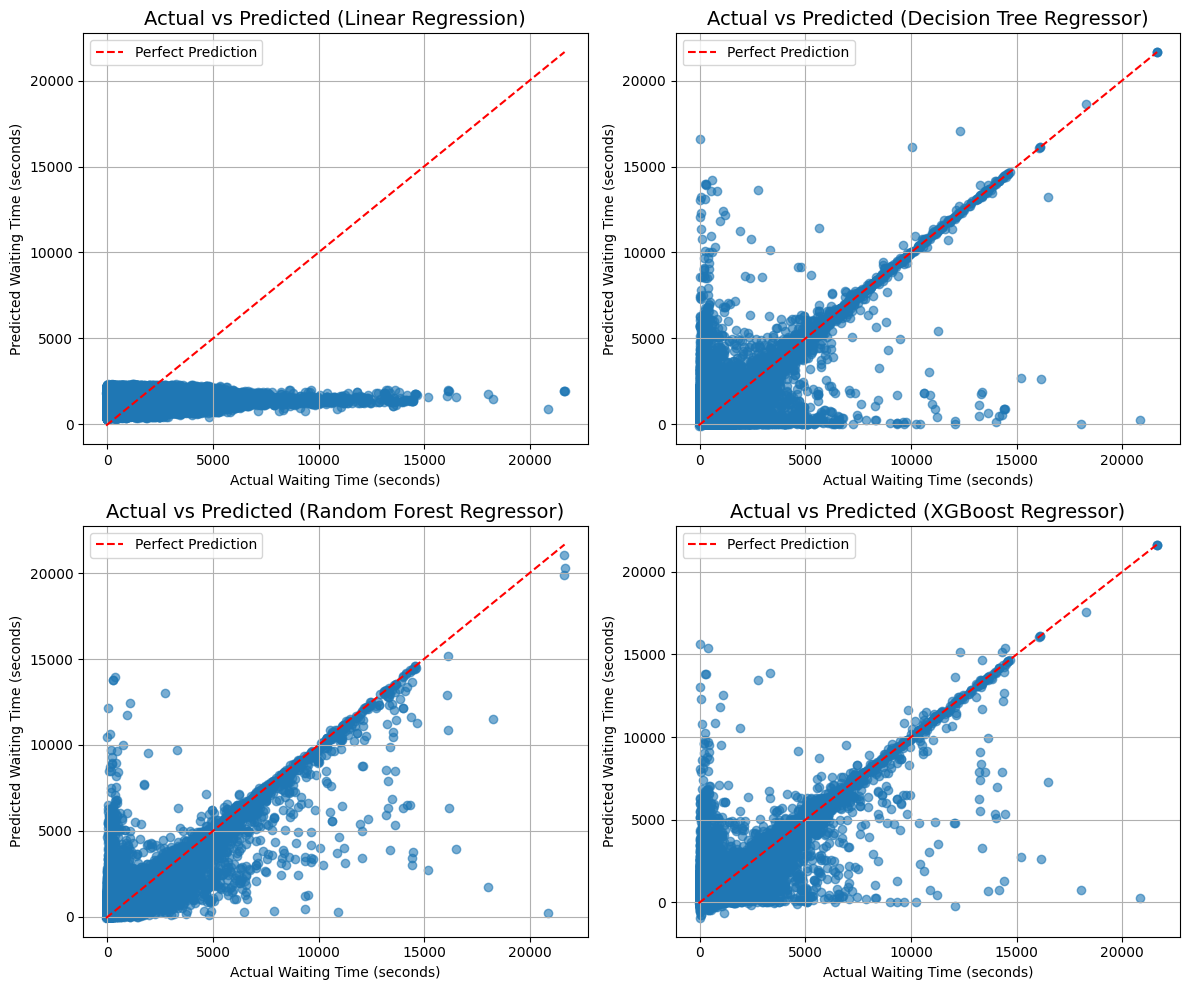


Summary of Results:
                                 MAE           MSE         RMSE        R²
Linear Regression        1074.271413  2.421485e+06  1556.112037  0.066889
Decision Tree Regressor   229.498625  5.218342e+05   722.380946  0.798913
Random Forest Regressor   227.263326  3.270972e+05   571.924093  0.873954
XGBoost Regressor         229.149365  3.924390e+05   626.449534  0.848775


In [8]:
import matplotlib.pyplot as plt

# Create a single figure with subplots (one subplot per model)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))  # Adjust rows/columns based on the number of models
axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration

# Loop through each model's predictions and plot in a separate subplot
for i, (name, pred) in enumerate(predictions.items()):
    axs[i].scatter(pred["Actual"], pred["Predicted"], alpha=0.6)
    axs[i].plot(
        [min(pred["Actual"]), max(pred["Actual"])],
        [min(pred["Actual"]), max(pred["Actual"])],
        color="red",
        linestyle="--",
        label="Perfect Prediction",
    )
    axs[i].set_title(f"Actual vs Predicted ({name})", fontsize=14)
    axs[i].set_xlabel("Actual Waiting Time (seconds)", fontsize=10)
    axs[i].set_ylabel("Predicted Waiting Time (seconds)", fontsize=10)
    axs[i].legend()
    axs[i].grid()

# Adjust layout and show the merged plot
plt.tight_layout()
plt.show()

# Display all results in a single table
results_df = pd.DataFrame(results).T
print("\nSummary of Results:")
print(results_df)



LIME Explanation for Random Forest Regressor:


ExactExplainer explainer: 56011it [19:27, 47.54it/s]                           



SHAP Explanation for XGBoost Regressor:


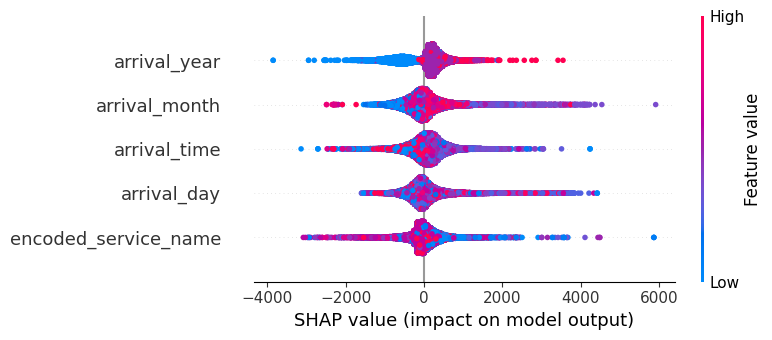

In [17]:
# Libraries for LIME and SHAP
import shap
import lime.lime_tabular

# ----------------------------
# LIME Explanation for Random Forest Regressor (Example)
# ----------------------------
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=[
        "encoded_service_name",
        "arrival_time",
        "arrival_day",
        "arrival_month",
        "arrival_year",
    ],
    class_names=["waiting_time"],
    mode="regression",
)

print("\nLIME Explanation for Random Forest Regressor:")
lime_exp_rf = lime_explainer.explain_instance(
    data_row=X_test[0],
    predict_fn=rfr_model.predict,
    num_features=4,  # Number of features to display in explanation
)
lime_exp_rf.show_in_notebook(show_table=True)

# ----------------------------
# SHAP Explanation for XGBoost Regressor (Example)
# ----------------------------
shap.initjs()  # Initialize JavaScript visualization for SHAP plots

shap_explainer_xgb = shap.Explainer(
    xgb_model.predict, X_train
)  # Use SHAP Explainer for XGBoost model
shap_values_xgb = shap_explainer_xgb(X_test)

print("\nSHAP Explanation for XGBoost Regressor:")
shap.summary_plot(
    shap_values_xgb,
    feature_names=[
        "encoded_service_name",
        "arrival_time",
        "arrival_day",
        "arrival_month",
        "arrival_year",
    ],
)

# SHAP Force Plot (Local Explanation for First Instance in Test Set)
shap.force_plot(
    shap_values_xgb[0].base_values,
    shap_values_xgb[0].values,
    feature_names=[
        "encoded_service_name",
        "arrival_time",
        "arrival_day",
        "arrival_month",
        "arrival_year",
    ],
)

### Real-Time Prediction

In [18]:
def predict_waiting_time(model,service_name):
    # Load the saved model and encoder
    with open(model, 'rb') as model_file:
        rfr_model, label_encoder = pickle.load(model_file)

    # Get current system time
    now = datetime.datetime.now()
    arrival_time = now.hour * 3600 + now.minute * 60 + now.second  # Convert to seconds
    arrival_day = now.day
    arrival_month = now.month
    arrival_year = now.year

    # Encode the service name
    encoded_service = label_encoder.transform([service_name])[0]

    # Prepare input data
    input_features = [[encoded_service, arrival_time, arrival_day, arrival_month, arrival_year]]

    # Make prediction
    predicted_wait_time = rfr_model.predict(input_features)[0]
    
    return round(predicted_wait_time, 2)

In [19]:
# Example Usage:
model_name = 'Models/Random_Forest_Regressor_model.pkl'
label_mapping = {
    'A/C Opening': 1,
    'Account Modification / Update': 2,
    'Accounts': 3,
    'Agent': 4,
    'Bill': 5,
    'Certificate': 6,
    'Cheque Book': 7,
    'Clearing Cheque': 8,
    'Credit Card': 9,
    'Credit Card Payment': 10,
    'Customer(Mobile Banking)': 11,
    'DPS': 12,
    'Debit Card': 13,
    'Deposit': 14,
    'Deposit (Current/SND)': 15,
    'FDR': 16,
    'Foreign Remittance': 17,
    'Fund Transfer': 18,
    'Internet Banking/2FA': 19,
    'P/O By Cash': 20,
    'P/O By Cheque': 21,
    'Prize Bond': 22,
    'Sanchay Patra': 23,
    'Shipping Guarantee': 24,
    'Statement': 25,
    'Torn Note Exchange': 26,
    'VIP Banking Customer': 27,
    'Withdrawal': 28,
    'Withdrawal (Current/SND)': 29,
    'Women Entrepreneurship Loan': 30
}
print("Label Encoding Mapping (SERVICE_NAME -> Encoded Value):")
for label, value in label_mapping.items():
    print(f"{label}: {value}")
service_number = int(input("Select Service Number: "))  # User selects service number
service = [label for label, value in label_mapping.items() if value == service_number][0]
predicted_time = predict_waiting_time(model_name, service)
print(f"Predicted Waiting Time: {predicted_time} seconds")

Label Encoding Mapping (SERVICE_NAME -> Encoded Value):
A/C Opening: 1
Account Modification / Update: 2
Accounts: 3
Agent: 4
Bill: 5
Certificate: 6
Cheque Book: 7
Clearing Cheque: 8
Credit Card: 9
Credit Card Payment: 10
Customer(Mobile Banking): 11
DPS: 12
Debit Card: 13
Deposit: 14
Deposit (Current/SND): 15
FDR: 16
Foreign Remittance: 17
Fund Transfer: 18
Internet Banking/2FA: 19
P/O By Cash: 20
P/O By Cheque: 21
Prize Bond: 22
Sanchay Patra: 23
Shipping Guarantee: 24
Statement: 25
Torn Note Exchange: 26
VIP Banking Customer: 27
Withdrawal: 28
Withdrawal (Current/SND): 29
Women Entrepreneurship Loan: 30
Predicted Waiting Time: 1689.52 seconds
